# Credit Card Fraud Detection (ML)

Following up with the results seen in the previous notebook, we will now try to build a model that can predict whether a transaction is fraudulent or not.

## Import libraries and Load data

In [2]:
 # import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5, 5)

In [3]:
# load data
df = pd.read_csv('../data/processed/creditcard_new.csv')

In [4]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v23,v24,v25,v26,v27,v28,amount,fraud,hour,amount_logged
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,5.008166
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.993252
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,5.936665
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,4.816322
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,4.248495


In [5]:
df.var(axis=0)

v1                   3.836489
v2                   2.726820
v3                   2.299029
v4                   2.004684
v5                   1.905081
v6                   1.774946
v7                   1.530401
v8                   1.426479
v9                   1.206992
v10                  1.185594
v11                  1.041855
v12                  0.998403
v13                  0.990571
v14                  0.918906
v15                  0.837803
v16                  0.767819
v17                  0.721373
v18                  0.702539
v19                  0.662662
v20                  0.594325
v21                  0.539526
v22                  0.526643
v23                  0.389951
v24                  0.366808
v25                  0.271731
v26                  0.232543
v27                  0.162919
v28                  0.108955
amount           62560.069046
fraud                0.001725
hour               173.839766
amount_logged        3.805565
dtype: float64

We will start by looking at which features are the most important in our dataset. We will use methods such as variance thresholding, forward selection, backward elimination, and recursive feature elimination to select the most important features.  
First, we start by dropping the hour feature since it clearly has no predictive power (we tried using it in some models and the score didn't change at all) and the amount feature since we will be using the log of the amount feature instead.

In [6]:
df.drop(['amount', 'hour'], axis=1, inplace=True)

## Model Selection

Given the size of the dataset in our hands, and the nature of the problem (binary classification), here are the models that we are going to try:

- Logistic Regression
- K-Nearest Neighbors
- SVM using Stochastic Gradient Descent 
- Decision Tree
- Random Forest
- XGBoost Classifier

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, roc_curve, auc, precision_recall_curve

In [8]:
# create X and y
X = df.drop(['fraud'], axis=1)
y = df['fraud']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Logistic Regression

The first model that we will try is the logistic regression model. Which is a good starting point due to its speed and simplicity.

In [44]:
from sklearn.linear_model import LogisticRegression

# create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# fit model
pipe.fit(X_train, y_train)

# predict on train and test
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

# evaluate model
print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.7452135493372607
Test f1 score:  0.7314285714285713


Since the proportions of classes in our dataset for the fraudulent class is very low, we evaluated the model using the f1 score to see how well it performs on the minority class, in terms of both the precision and the recall.  
We see that the model doesn't overfit, with an f1 score of 0.74, which is a good starting point.  
Our model was a bit slow to train, and this is due to the large size of the dataset.

In [45]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



Notice how the predictions on the class 0 were almost perfect, but we don't really care about that, we care about the model handles the class 1, which is the minority class.  
Given that the f1 score is 0.74, we can say that the model is doing a good job at predicting the minority class, we can work on the probability threshold to give more weight to the recall.  
Before doing that, let's see if we can improve the f1 score by tuning the hyperparameters.

In [46]:
# create grid
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10]
}

# change the solver 
pipe.set_params(logreg__solver='newton-cholesky', logreg__class_weight={0:1, 1:5})

# create gridsearch
gridsearch = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')

# fit gridsearch
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 5},
                                                           max_iter=1000,
                                                           solver='newton-cholesky'))]),
             n_jobs=-1, param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='f1')

In [47]:
# best params
print(gridsearch.best_params_)

# best score
print(gridsearch.best_score_)

{'logreg__C': 0.01}
0.8022585688375162


We got such a great improvement in the f1 score by tuning the hyperparameters and giving more weight to class 1.  
Let's look at the classification report of this new model.

In [48]:
y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.84      0.78        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



The precision dropped, but the recall increased significantly, all we need to do now is to calibrate the probability threshold to get the best ration between recall and precision.

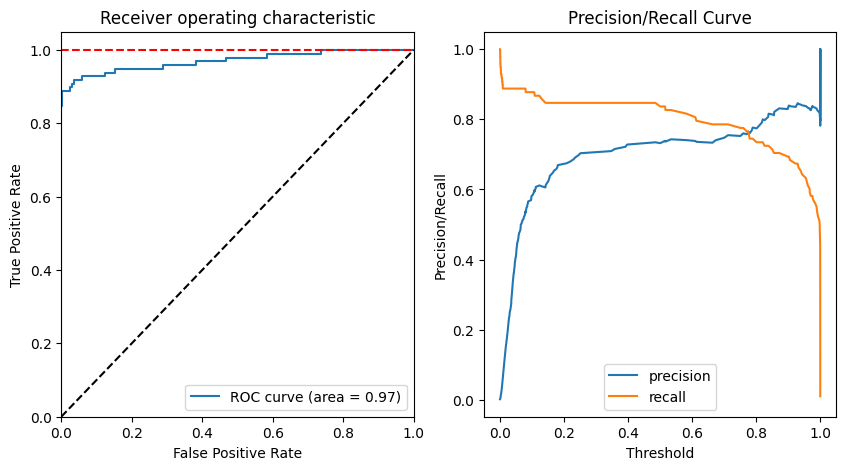

In [74]:
# plot the roc curve

# predict probabilities
y_pred_prob = gridsearch.predict_proba(X_test)[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# calculate auc
roc_auc = auc(fpr, tpr)

# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# roc curve
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot([0, 1], [1, 1], 'r--')

ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])

ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[0].set_title('Receiver operating characteristic')
ax[0].legend(loc="lower right")

# precision recall curve
ax[1].plot(thresholds, precision[:-1], label='precision')
ax[1].plot(thresholds, recall[:-1], label='recall')

ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Precision/Recall')

ax[1].set_title('Precision/Recall Curve')
ax[1].legend(loc="lower center")

plt.show()

The default threshold of 0.5 looks like a good choice, but we can have better results if we decrease it a little bit, let's try for example a value of 0.4, we don't really need to make recall and precision equal, what matters is the recall.

In [81]:
# predict on test with the threshold of 0.4
y_pred = (y_pred_prob > 0.4).astype(int)

# evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.85      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



Now we see that out of fradulent transactions, our model can predict 85% of them, which is so good for a first model. Also note that 73% of the transactions that our model predicted as fraudulent are actually fraudulent, which is also good.

### K-Nearest Neighbors

The second model that we will try is the K-Nearest Neighbors model. This model also requires scaling the data, we will do that using the standard scaler.

In [88]:
from sklearn.neighbors import KNeighborsClassifier

# create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# fit model
pipe.fit(X_train, y_train)

# predict on train and test
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

# evaluate model
print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.8650904033379694
Test f1 score:  0.8571428571428572


There is no overfitting, the f1 score is higher than that of the logistic regression model. The major drawback of this model is that it is very slow to train and predict, which is a problem when we have new data coming in.  
We are only going to look at the classification report of the model, we cannot tune the hyperparameters of this model, since it's gonna take an even longer time.

In [89]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



We see that the precision is very high (93%) meaning that the model knows how to predict the minority class, the recall on the other hand is 80%, it is acceptable, but we need to find a way to make recall and precision even.

In [92]:
y_pred_prob = pipe.predict_proba(X_test)[:, 1]

In [104]:
# predict 
y_pred = (y_pred_prob > 0.3).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



With a probability threshold of 0.3, we get very high recall (86%) and precision (87%), these metrics are very good for our problem, and we also keep the perfect scores on the class 0.  
We can't tell if this model is better overall, because of its runtime, but we can say that it is better at predicting the minority class.

### Support Vector Classifier

The third model that we will try is the Support Vector Machines model. This model also requires scaling the data, we will do that using the standard scaler.  
We will not use the standard SVC classifier, since our data is very large, we are going to use the Stochastic Gradient Descent approach.  
By default, the SGDClassifier mnimizes the hinge loss function, which is the one used with the SVM classifier.  
The variance of the score we desire is very high, but due to the model being fast to train, we are going to use cross validation to evaluate the model.

In [183]:
from sklearn.linear_model import SGDClassifier

# create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(class_weight={0:1, 1:5}))
])

# fit model
pipe.fit(X_train, y_train)

# cross validation
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')

# print scores
print(scores)

# print mean score
print('Average f1 score {:.2f}'.format(scores.mean()))

[0.74829932 0.77707006 0.75324675 0.79470199 0.73548387]
Average f1 score 0.76


Eventhough the model is fast and efficient to work with, we see that the f1 score is very low compared to other models, let's see if we can make it better if we work on the hyperparameters

In [187]:
param_grid = {
    'sgd__alpha': [0.001, 0.01, 0.1, 1, 10],
    'sgd__penalty': ['l1', 'l2']
}

# instantiate grid search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')

# fit the grid
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDClassifier(alpha=0.001,
                                                      class_weight={0: 1,
                                                                    1: 5}))]),
             param_grid={'sgd__alpha': [0.001, 0.01, 0.1, 1, 10],
                         'sgd__penalty': ['l1', 'l2']},
             scoring='recall')

In [188]:
# print best parameters and score
print(grid.best_score_)
print(grid.best_params_)

0.8221681272314184
{'sgd__alpha': 0.001, 'sgd__penalty': 'l1'}


In [189]:
# predict on test
pipe = grid.best_estimator_
y_pred = pipe.predict(X_test)

# evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.84      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



While tuning the svm model using SGD, we got a good improvement in the recall. However, the precision dropped, and this is because we couldn't find a good balance between these two metrics, this is because the model doesn't support the probability estimation, so we can't find the this balance, as we did using the logistic regression model and KNN models.
This model however is very fast to train and predict, so it can be used in real time applications, if we don't have strict rules regarding precision.

### Decision Trees

The fourth model is the Decision Tree model. This model doesn't require scaling the data, so we will use the original data.

In [192]:
from sklearn.tree import DecisionTreeClassifier

# create the model
dt = DecisionTreeClassifier(max_depth=3, class_weight={0:1, 1:5})

# fit the model
dt.fit(X_train, y_train)

# predict on train and test
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# evaluate model
print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.8250319284802043
Test f1 score:  0.784688995215311


The first innocent model using a depth of 3 (to get a feel of the data) leads to impressive results, we see that the f1 score between the train and test sets differ a little bit, but we I think that we can easily fix this, and maybe increase our scores by tuning the hyperparameters.

In [193]:
# parameters
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3]
}

# instantiate grid search
grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1')

# fit the grid
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 5},
                                              max_depth=3),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3]},
             scoring='f1')

In [194]:
# print best parameters and score
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8103158173457261
{'max_depth': 3, 'min_weight_fraction_leaf': 0}
DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=3,
                       min_weight_fraction_leaf=0)


In [217]:
dt = grid.best_estimator_

# predict on test
y_pred = dt.predict(X_test)
y_pred_prob = dt.predict_proba(X_test)[:, 1]

In [220]:
# evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.84      0.78        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



The hyperparameter tuning phase didn't lead to a massive change in the scores, but the model we have is very good.  
Let's plot the precision accuracy curve again.

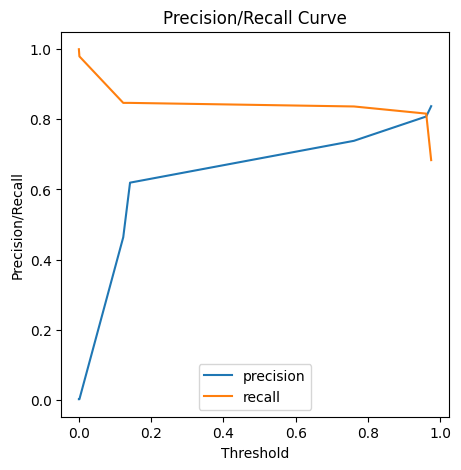

In [222]:
# get the scores for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# plot
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')

plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')

plt.title('Precision/Recall Curve')
plt.legend(loc="lower center")

plt.show()

Impressively, our model gives a lot of importance to the minority class, which is the class that we care about.  
From the plot, we see that it would be better if we increase the threshold, as it wouldn't impact the recall, it's gonna remain high, but the precision will increase.

In [226]:
# using a threshold of 0.8
y_pred = (y_pred_prob > 0.8).astype(int)

# evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.82      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Indeed, the f1 score, precision and recall are all higher, this is the best model using decision trees. It is also better than the logistic regression model, and the KNN model, because it has better results than the first, and it runs a lot faster than the second.

### Random Forests

The fifth model is the Random Forest model. This model doesn't require scaling the data, so we will use the original data.  
Note that this mode requires a lot more hyperparameters tuning.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# create the model
rf = RandomForestClassifier(class_weight={0:1, 1:5})

# fit the model
rf.fit(X_train, y_train)

# predict on train and test
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# evaluate model
print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  1.0
Test f1 score:  0.8474576271186441


We notice that the model is overfitting, but its scores are promising, we just need to work on the parameters of the model as we did with the previous ones, but this step would take some time since the model isn't fast to train.

In [15]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [26]:
rf = RandomForestClassifier(class_weight={0:1, 1:5}, max_features='sqrt', max_samples=0.5, max_depth=8)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.8849315068493151
Test f1 score:  0.8478260869565216


Notice how we managed to get a very high f1 score, and the model is not overfitting, this is a very good model. The parameters were obtained manually while following the [scikit-learn guide](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees).  
Let us work on the probability threshold to get the best results.

In [27]:
y_pred = y_test_pred
y_pred_prob = rf.predict_proba(X_test)[:, 1]

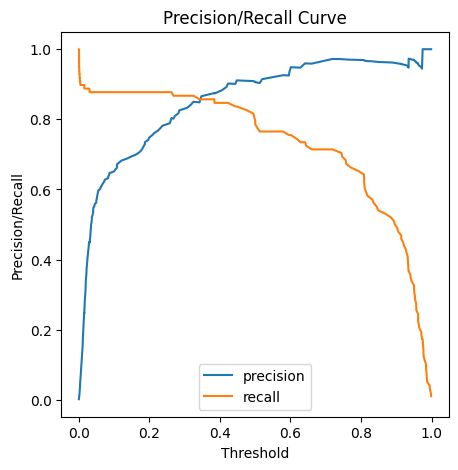

In [28]:
# plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')

plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')

plt.title('Precision/Recall Curve')
plt.legend(loc="lower center")

plt.show()

The plot above shows us that we need to lower the threshold.

In [38]:
y_pred = (y_pred_prob > 0.3).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.87      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Using a threshold of 0.3, we get a very high recall (86%), and a very high precision (83%).  
Given these results, we can say that our random forest model is the best model we have so far, it is better than the decision tree model, and it is also better than the logistic regression model. It outperforms these models in all the metric, eventhough it is slower to train, but not by a lot (from 1 to 2 minutes).  
This method is known as the ensemble bagging method, we will use boosting next using the XGBoost library.

### XGBoost Classifier

In [9]:
import xgboost as xgb

# create the model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric='auc')

# fit the model
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
# predict on train and test
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# evaluate model
print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.9658792650918635
Test f1 score:  0.870967741935484


We got such a high f1 score with this model, and the model is extremely fast, let's work on the regularization parameters for a more robust model.  
The main parameters that we will work on are `learning_rate`, `reg_lambda`, `scale_pos_weight`, `colsample_bytree` and `subsample`.

In [11]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric='auc', scale_pos_weight=3, reg_lambda=10, learning_rate=0.2, subsample=0.8, colsample_bytree=0.7, max_depth=7)

xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print('Train f1 score: ', f1_score(y_train, y_train_pred))
print('Test f1 score: ', f1_score(y_test, y_test_pred))

Train f1 score:  0.9059139784946236
Test f1 score:  0.8829787234042554


With this new set of parameters, we succeeded in reducing overfitting, the training score decreased while the testing score increased, let's work with this last model and try to see if we can balance the predictions by working on the threshold.

In [13]:
y_pred = y_test_pred
y_pred_prob = xgb_clf.predict_proba(X_test)[:,1]

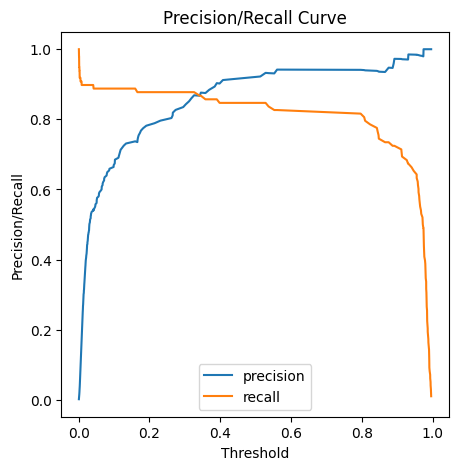

In [14]:
# plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')

plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')

plt.title('Precision/Recall Curve')
plt.legend(loc="lower center")

plt.show()

In [15]:
y_pred = (y_pred_prob > 0.33).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.87      0.87        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



With a threshold of 0.33, we get the following results:

- 87% of actual frauds are detected successfully
- 87% of transactions labeled as fraud by our model are actual frauds  

This is the best model so far, both in terms of the accuracy of the model, and in terms of the time and complexity of the model.

## Conclusion

Throughout this project, we have seen how to deal with imbalanced data, and how to build a model that can predict the minority class with a high accuracy.  
Here is what we have covered:

- Loading the Data
- Data Cleaning and Visualization
- Exploratory Data Analysis
- Data Preprocessing
- Model Building
- Model Evaluation

There is one thing I would like to mention, it's that people might think of performing oversampling or undersampling on the data, but this is not a good idea, because those methods could only serve as a last resort if we can't get a good model working on the data we have at hand, and it needs to be avoided for several reasons, one of which is that it might show good results on fabricated data, but it won't generalize well on real data. And in our case, even when the fraud class was extremely rare, we got very good models that can predict the positive class with a high accuracy.